In [1]:
# imports

# Models
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier as lgbm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# preprocessors
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest, SelectFromModel, RFE
from sklearn.impute import SimpleImputer

# Samplers
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# metrics and splitters
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split

# utils
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sys
import matplotlib_venn as venn

# progress bar
from ipywidgets import IntProgress
from IPython.display import display

from scipy.stats import pearsonr

sys.path.append("../")

import utils_ML as uml
import AtlasAnalysisFunctions as AAF

In [2]:
data_combat = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

{2: 2.6564102564102563, 9: 0.7194444444444444, 11: 1.3282051282051281, 3: 2.3022222222222224, 1: 0.3453333333333333, 7: 3.453333333333333, 5: 1.4388888888888889, 0: 0.4427350427350427, 8: 1.5014492753623188, 12: 1.4388888888888889, 10: 1.3282051282051281, 6: 0.5755555555555556, 13: 1.817543859649123, 14: 3.453333333333333, 4: 0.8222222222222222}


In [3]:
preprocessor = Pipeline(steps=[
    ('filter', uml.FilterByClass(keep=True)),
    ('imputer', uml.LowestValueImputer())
])

prep_data = preprocessor.fit_transform(data, targets)

In [3]:
filtering = uml.FilterByOccurence(.5)
exp_prep_data = filtering.fit_transform(np.exp2(data), targets)
exp_prep_data = pd.DataFrame(exp_prep_data, columns = filtering.filtered_proteins)

In [29]:
data.min().min()

-7.585772958447452

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


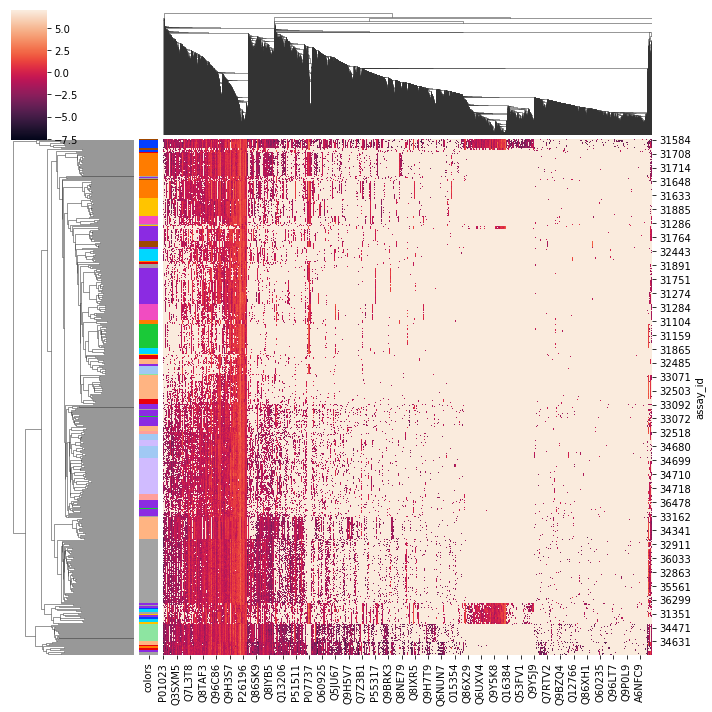

In [30]:
sns.clustermap(data.fillna(7), row_colors=meta.colors), row_colors=meta.colors)

In [7]:
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

mapped_df = pd.DataFrame({"colors": colors, "Group": meta.Group.unique()})
meta["colors"] = meta.Group.apply(lambda x: mapped_df[mapped_df.Group == x].colors.unique()[0])

<Figure size 720x720 with 0 Axes>

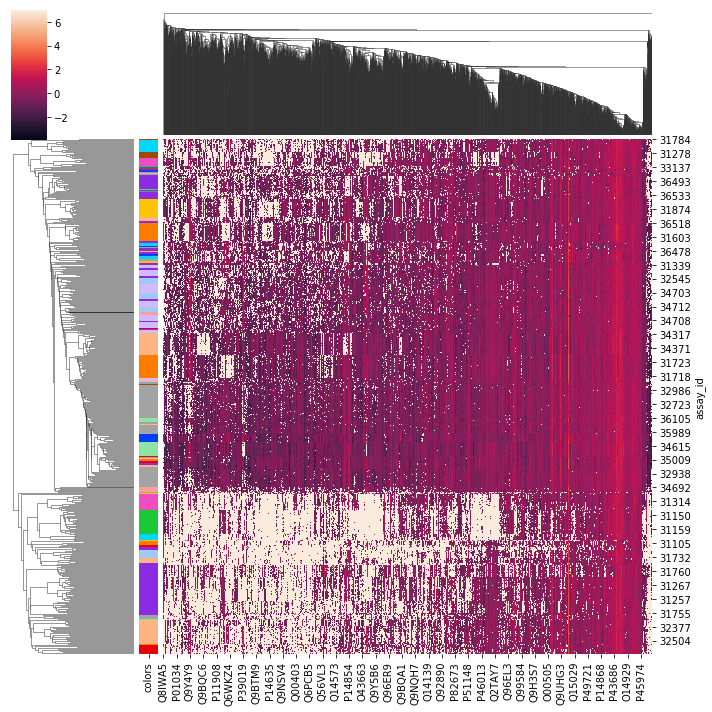

In [31]:
plt.figure(figsize=(10,10))
sns.clustermap(np.log(exp_prep_data).fillna(7), row_colors=meta.colors)

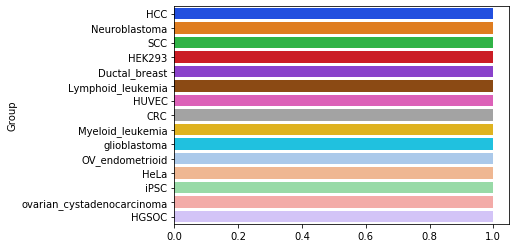

In [50]:
sns.barplot(data=mapped_df, x=[1]*15, y="Group", palette=mapped_df.colors.values)

In [45]:
correlation_matrix = exp_prep_data.corr(method="pearson", min_periods=100)

A0AVT1    A0MZ66    A0PJW6    A1X283    A2RRP1    A3KMH1    A3KN83  \
A0AVT1  1.000000 -0.028411 -0.110703  0.075053 -0.145106 -0.069014  0.030422   
A0MZ66 -0.028411  1.000000  0.095909  0.028291 -0.055819  0.198077  0.164911   
A0PJW6 -0.110703  0.095909  1.000000 -0.009977 -0.172982 -0.023289 -0.219288   
A1X283  0.075053  0.028291 -0.009977  1.000000  0.049380 -0.056000  0.006257   
A2RRP1 -0.145106 -0.055819 -0.172982  0.049380  1.000000 -0.039407  0.106998   
...          ...       ...       ...       ...       ...       ...       ...   
Q9Y6W3 -0.048621  0.331074 -0.052224 -0.118957  0.426601  0.218979  0.319246   
Q9Y6W5  0.291293 -0.005413  0.137770  0.128266 -0.181189 -0.095708 -0.124543   
Q9Y6X9 -0.078837  0.136082  0.010278 -0.106118  0.066341  0.229901  0.202721   
Q9Y6Y0  0.010271  0.188086  0.042269  0.148114 -0.045681 -0.015404  0.205611   
Q9Y6Y8  0.297325 -0.013380 -0.031323  0.038076 -0.159244  0.300376  0.124217   

          A4D1E9    A5YKK6    A6NDG6  ...    Q9Y6J9    Q9Y6M5    Q9Y6N5  \
A0AVT1 -0.088680  0.102409 -0.027786  ...  0.053254 -0.009647  0.031065   
A0MZ66 -0.131558 -0.062822 -0.192210  ...  0.041248  0.341742 -0.090296   
A0PJW6 -0.035807 -0.294473 -0.019396  ... -0.018591  0.156776 -0.149304   
A1X283 -0.187947 -0.109188 -0.069891  ... -0.070134  0.038272 -0.278653   
A2RRP1  0.183124  0.059055 -0.189534  ... -0.036488  0.037322  0.135721   
...          ...       ...       ...  ...       ...       ...       ...   
Q9Y6W3 -0.059764  0.120630  0.035049  ...  0.019167  0.288253 -0.034789   
Q9Y6W5 -0.315660 -0.153002 -0.015438  ...  0.101221 -0.051099 -0.178152   
Q9Y6X9 -0.125773 -0.004543  0.056212  ...  0.033992  0.070588 -0.202130   
Q9Y6Y0 -0.178893 -0.015618  0.118633  ... -0.071427  0.184532 -0.211337   
Q9Y6Y8 -0.158059  0.227350  0.184317  ... -0.024984  0.052536  0.009786   

          Q9Y6Q9    Q9Y6V7    Q9Y6W3    Q9Y6W5    Q9Y6X9    Q9Y6Y0    Q9Y6Y8  
A0AVT1 -0.257667 -0.323830 -0.048621  0.291293 -0.078837  0.010271  0.297325  
A0MZ66  0.336172 -0.193958  0.331074 -0.005413  0.136082  0.188086 -0.013380  
A0PJW6 -0.034054 -0.013563 -0.052224  0.137770  0.010278  0.042269 -0.031323  
A1X283  0.044279 -0.121956 -0.118957  0.128266 -0.106118  0.148114  0.038076  
A2RRP1  0.051369 -0.006153  0.426601 -0.181189  0.066341 -0.045681 -0.159244  
...          ...       ...       ...       ...       ...       ...       ...  
Q9Y6W3  0.086219 -0.145882  1.000000 -0.228122  0.181282  0.108760  0.043636  
Q9Y6W5 -0.017524 -0.214438 -0.228122  1.000000  0.000184  0.005799  0.069299  
Q9Y6X9  0.230321  0.172414  0.181282  0.000184  1.000000  0.227164  0.101964  
Q9Y6Y0  0.142763  0.039849  0.108760  0.005799  0.227164  1.000000 -0.096936  
Q9Y6Y8 -0.112614 -0.276909  0.043636  0.069299  0.101964 -0.096936  1.000000  

[2615 rows x 2615 columns]

In [75]:
def correlation_matrix(matrix):
    
    dfcols = pd.DataFrame(columns=matrix.columns)
    corrs = dfcols.transpose().join(dfcols, how ="outer")
    pvalues = dfcols.transpose().join(dfcols, how="outer")

    uncalculatable = []

    for var1 in exp_prep_data.columns:
        for var2 in exp_prep_data.columns:
            
            if var1 == var2:
                    corrs[var1][var2], pvalues[var1][var2] = 1, 0
                    continue

            mask = matrix.loc[:,var1].notnull() & matrix.loc[:,var2].notnull()
    
            selection = matrix.loc[mask, [var1,var2]]

            # Approximately 20 % of datapoint pairs must be retained
            if len(selection) > 100:
                corrs[var1][var2], pvalues[var1][var2] = pearsonr(selection.loc[:,var1], selection.loc[:,var2])

            else:
                corrs[var1][var2], pvalues[var1][var2] = 0, 1
                uncalculatable.append([var1,var2])

    return corrs, pvalues, uncalculatable

In [76]:
corrs, pvalues, uncalculatable = correlation_matrix(exp_prep_data)

In [10]:
exp_prep_data

A0AVT1    A0MZ66    A0PJW6    A1X283    A2RRP1    A3KMH1  \
assay_id                                                               
30960     1.512593  1.040787  0.170890  0.158451  0.302098  0.494815   
30961     1.461746  1.019052  0.269378  0.208544  0.280234  0.509212   
31008     1.212666  0.887010  0.165177  0.199755  0.158191  0.214877   
31009     1.251711  0.819242  0.162849  0.197098  0.200327  0.212084   
31102          NaN       NaN       NaN       NaN       NaN  0.315349   
...            ...       ...       ...       ...       ...       ...   
36558     0.944822  1.300442       NaN       NaN       NaN  0.255004   
36563     0.860000  1.746543       NaN  0.930183       NaN       NaN   
36568     0.617522  0.996242       NaN  0.913312       NaN       NaN   
36573     0.657855  1.313998  0.673434  1.001576       NaN  0.185539   
36578     0.815099  0.982836       NaN  1.002730       NaN  0.382950   

            A3KN83    A4D1E9    A5YKK6    A6NDG6  ...    Q9Y6J9    Q9Y6M5  \
assay_id                                          ...                       
30960     0.290371  0.966687  0.860079  1.132640  ...  0.311818  0.354670   
30961     0.307174  0.960004  0.829201  1.170833  ...  0.291937  0.415235   
31008     0.368341  0.838966  0.895625  0.891768  ...  0.257538  0.566976   
31009     0.415595  0.931227  0.853018  0.794285  ...  0.308335  0.561892   
31102          NaN       NaN  1.199932       NaN  ...       NaN  1.196253   
...            ...       ...       ...       ...  ...       ...       ...   
36558     0.422604       NaN  0.457765  1.398810  ...       NaN  1.166487   
36563     0.306897       NaN  0.520797       NaN  ...       NaN  1.348579   
36568     0.300657       NaN  0.498781  1.717327  ...       NaN  0.903782   
36573          NaN       NaN  0.362399  0.768551  ...  0.352935  0.591066   
36578          NaN       NaN  0.490504       NaN  ...       NaN       NaN   

            Q9Y6N5    Q9Y6Q9    Q9Y6V7    Q9Y6W3    Q9Y6W5    Q9Y6X9  \
assay_id                                                               
30960     1.911921  0.154390  0.520209  0.553446  0.329758  0.440845   
30961     1.982190  0.188730  0.619154  0.602362  0.335675  0.460482   
31008     2.723916  0.308324  0.585581  0.164500  0.419604  0.307616   
31009     2.825317  0.281697  0.604419  0.162179  0.494950  0.391899   
31102          NaN       NaN       NaN       NaN       NaN       NaN   
...            ...       ...       ...       ...       ...       ...   
36558     0.526233       NaN  0.622524  0.479312  0.868205  0.549531   
36563     0.829116  0.207816       NaN       NaN  0.784549  0.657817   
36568     0.874528  0.207018  0.522512       NaN  1.190915  0.244890   
36573     0.425064       NaN  0.607764       NaN  0.889286  0.392924   
36578     0.458712       NaN  0.635664  0.336424  0.434978  0.528068   

            Q9Y6Y0    Q9Y6Y8  
assay_id                      
30960     0.578063  0.724107  
30961     0.480931  0.657400  
31008     0.464130  0.749596  
31009     0.373511  0.658392  
31102          NaN  0.307507  
...            ...       ...  
36558     1.326739  0.352428  
36563     0.320836  1.290040  
36568     0.450411  0.736769  
36573     0.651474  0.268677  
36578          NaN       NaN  

[518 rows x 2615 columns]

In [11]:
exp_prep_data.iloc[:,0]

assay_id
30960    1.512593
30961    1.461746
31008    1.212666
31009    1.251711
31102         NaN
           ...   
36558    0.944822
36563    0.860000
36568    0.617522
36573    0.657855
36578    0.815099
Name: A0AVT1, Length: 518, dtype: float64

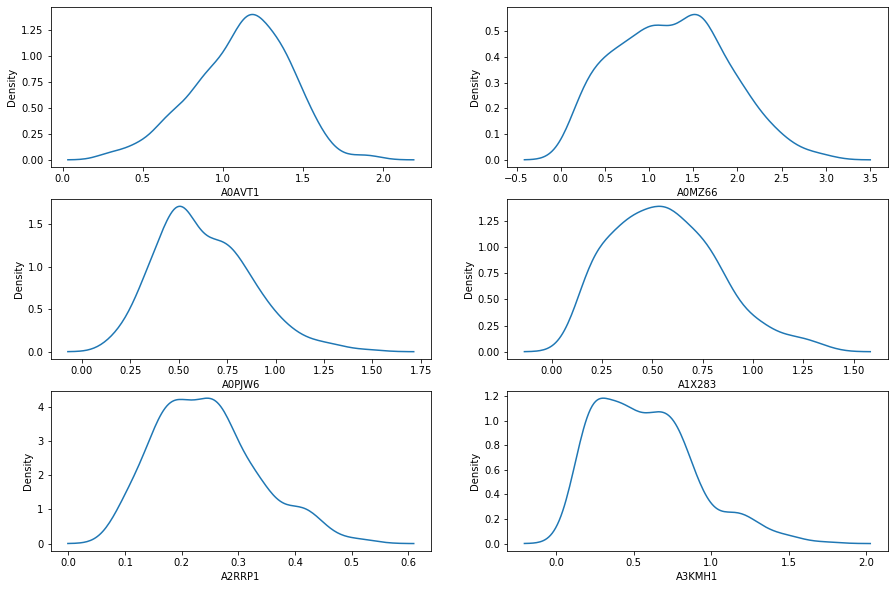

In [15]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(15,10))

for i, axes in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    sns.kdeplot(exp_prep_data.iloc[:,i], ax=axes)

In [25]:
exp_prep_data.loc[:,"P62805"]

assay_id
30960     6.903361
30961     6.739973
31008     9.831121
31009     9.748467
31102    13.465144
           ...    
36558    15.911867
36563     8.396901
36568     9.515417
36573    19.523954
36578    21.161050
Name: P62805, Length: 518, dtype: float64

In [6]:
mean_std_df = pd.DataFrame({"mean": exp_prep_data.mean(), "std": exp_prep_data.std()})
mean_std_df.head()

mean       std
A0AVT1  1.118448  0.295085
A0MZ66  1.254223  0.618751
A0PJW6  0.628416  0.238873
A1X283  0.563470  0.260787
A2RRP1  0.243637  0.088711

In [51]:
samples = np.random.normal(m - 2.5*s, s, 10000)
samples[samples < 0] = 0

array([-0.04857798,  0.31444738, -0.95200479, ...,  0.11038443,
       -0.50688076, -0.55888314])

In [5]:
exp_prep_data[targets == 1]

A0AVT1    A0MZ66    A0PJW6    A1X283    A2RRP1    A3KMH1  \
assay_id                                                               
31254     1.034029  2.347473       NaN       NaN       NaN       NaN   
31255     0.905537  2.338805       NaN       NaN  0.172621       NaN   
31256     1.073192  2.313092       NaN       NaN  0.164679  0.191080   
31257     0.611142  2.072824       NaN  0.320946       NaN       NaN   
31258     0.889515  2.389066  0.914266       NaN  0.174009       NaN   
...            ...       ...       ...       ...       ...       ...   
36558     0.944822  1.300442       NaN       NaN       NaN  0.255004   
36563     0.860000  1.746543       NaN  0.930183       NaN       NaN   
36568     0.617522  0.996242       NaN  0.913312       NaN       NaN   
36573     0.657855  1.313998  0.673434  1.001576       NaN  0.185539   
36578     0.815099  0.982836       NaN  1.002730       NaN  0.382950   

            A3KN83  A4D1E9    A5YKK6    A6NDG6  ...    Q9Y6J9    Q9Y6M5  \
assay_id                                        ...                       
31254     0.252206     NaN  0.370429  0.685058  ...       NaN       NaN   
31255     0.248402     NaN  0.445104  0.678210  ...       NaN       NaN   
31256     0.236367     NaN  0.346909  0.640805  ...       NaN       NaN   
31257     0.240996     NaN  0.352731  1.035426  ...       NaN       NaN   
31258     0.397146     NaN  0.442100  1.067462  ...       NaN       NaN   
...            ...     ...       ...       ...  ...       ...       ...   
36558     0.422604     NaN  0.457765  1.398810  ...       NaN  1.166487   
36563     0.306897     NaN  0.520797       NaN  ...       NaN  1.348579   
36568     0.300657     NaN  0.498781  1.717327  ...       NaN  0.903782   
36573          NaN     NaN  0.362399  0.768551  ...  0.352935  0.591066   
36578          NaN     NaN  0.490504       NaN  ...       NaN       NaN   

            Q9Y6N5    Q9Y6Q9    Q9Y6V7    Q9Y6W3    Q9Y6W5    Q9Y6X9  \
assay_id                                                               
31254          NaN  0.524894  0.518711       NaN  0.814373  0.495889   
31255          NaN  0.631841       NaN  0.577011  0.806950  0.305001   
31256          NaN  0.695081       NaN       NaN  0.475478  0.464144   
31257          NaN  0.604950  0.492420  0.346558  0.769935  0.295048   
31258          NaN  0.725395  0.508206  0.357851  0.497843  0.638741   
...            ...       ...       ...       ...       ...       ...   
36558     0.526233       NaN  0.622524  0.479312  0.868205  0.549531   
36563     0.829116  0.207816       NaN       NaN  0.784549  0.657817   
36568     0.874528  0.207018  0.522512       NaN  1.190915  0.244890   
36573     0.425064       NaN  0.607764       NaN  0.889286  0.392924   
36578     0.458712       NaN  0.635664  0.336424  0.434978  0.528068   

            Q9Y6Y0    Q9Y6Y8  
assay_id                      
31254     0.427353  0.667699  
31255          NaN  0.937501  
31256          NaN  1.110803  
31257          NaN  0.892599  
31258     0.669221  1.040693  
...            ...       ...  
36558     1.326739  0.352428  
36563     0.320836  1.290040  
36568     0.450411  0.736769  
36573     0.651474  0.268677  
36578          NaN       NaN  

[100 rows x 2615 columns]

In [4]:
# Imputation method

def generate_point(m, s):

    count = 0
    while count < 100:
        new_point = np.random.normal(m, s)

        if new_point > 0:
            return new_point
    return 0


def impute(col: pd.Series):

    arr = np.array(col)
    m, s = np.nanmean(arr), np.nanstd(arr)

    new = np.array([generate_point(m-2.2*s, s/2) if np.isnan(x) else x for x in arr])

    return pd.Series(new, index=col.index)

imputed_data = exp_prep_data.apply(lambda x: impute(x), axis=0)

In [5]:
imputed_data

A0AVT1    A0MZ66    A0PJW6    A1X283    A2RRP1    A3KMH1  \
assay_id                                                               
30960     1.512593  1.040787  0.170890  0.158451  0.302098  0.494815   
30961     1.461746  1.019052  0.269378  0.208544  0.280234  0.509212   
31008     1.212666  0.887010  0.165177  0.199755  0.158191  0.214877   
31009     1.251711  0.819242  0.162849  0.197098  0.200327  0.212084   
31102     0.453983  0.055240  0.063314  0.030250  0.103631  0.315349   
...            ...       ...       ...       ...       ...       ...   
36558     0.944822  1.300442  0.136233  0.066813  0.037474  0.255004   
36563     0.860000  1.746543  0.048189  0.930183  0.076841  0.052784   
36568     0.617522  0.996242  0.167598  0.913312  0.020658  0.024394   
36573     0.657855  1.313998  0.673434  1.001576  0.083533  0.185539   
36578     0.815099  0.982836  0.173772  1.002730  0.154879  0.382950   

            A3KN83    A4D1E9    A5YKK6    A6NDG6  ...    Q9Y6J9    Q9Y6M5  \
assay_id                                          ...                       
30960     0.290371  0.966687  0.860079  1.132640  ...  0.311818  0.354670   
30961     0.307174  0.960004  0.829201  1.170833  ...  0.291937  0.415235   
31008     0.368341  0.838966  0.895625  0.891768  ...  0.257538  0.566976   
31009     0.415595  0.931227  0.853018  0.794285  ...  0.308335  0.561892   
31102     0.118094  0.010120  1.199932  0.398989  ...  0.057797  1.196253   
...            ...       ...       ...       ...  ...       ...       ...   
36558     0.422604  0.004440  0.457765  1.398810  ...  0.090526  1.166487   
36563     0.306897  0.215237  0.520797  0.157237  ...  0.094638  1.348579   
36568     0.300657  0.151049  0.498781  1.717327  ...  0.062418  0.903782   
36573     0.027944  0.227658  0.362399  0.768551  ...  0.352935  0.591066   
36578     0.106450  0.047693  0.490504  0.241230  ...  0.106091  0.004368   

            Q9Y6N5    Q9Y6Q9    Q9Y6V7    Q9Y6W3    Q9Y6W5    Q9Y6X9  \
assay_id                                                               
30960     1.911921  0.154390  0.520209  0.553446  0.329758  0.440845   
30961     1.982190  0.188730  0.619154  0.602362  0.335675  0.460482   
31008     2.723916  0.308324  0.585581  0.164500  0.419604  0.307616   
31009     2.825317  0.281697  0.604419  0.162179  0.494950  0.391899   
31102     0.243563  0.070792  0.229328  0.061989  0.161095  0.124411   
...            ...       ...       ...       ...       ...       ...   
36558     0.526233  0.074200  0.622524  0.479312  0.868205  0.549531   
36563     0.829116  0.207816  0.097448  0.074653  0.784549  0.657817   
36568     0.874528  0.207018  0.522512  0.029429  1.190915  0.244890   
36573     0.425064  0.094649  0.607764  0.151722  0.889286  0.392924   
36578     0.458712  0.014458  0.635664  0.336424  0.434978  0.528068   

            Q9Y6Y0    Q9Y6Y8  
assay_id                      
30960     0.578063  0.724107  
30961     0.480931  0.657400  
31008     0.464130  0.749596  
31009     0.373511  0.658392  
31102     0.007263  0.307507  
...            ...       ...  
36558     1.326739  0.352428  
36563     0.320836  1.290040  
36568     0.450411  0.736769  
36573     0.651474  0.268677  
36578     0.107894  0.326443  

[518 rows x 2615 columns]

Text(0.5, 1.0, 'scaled log')

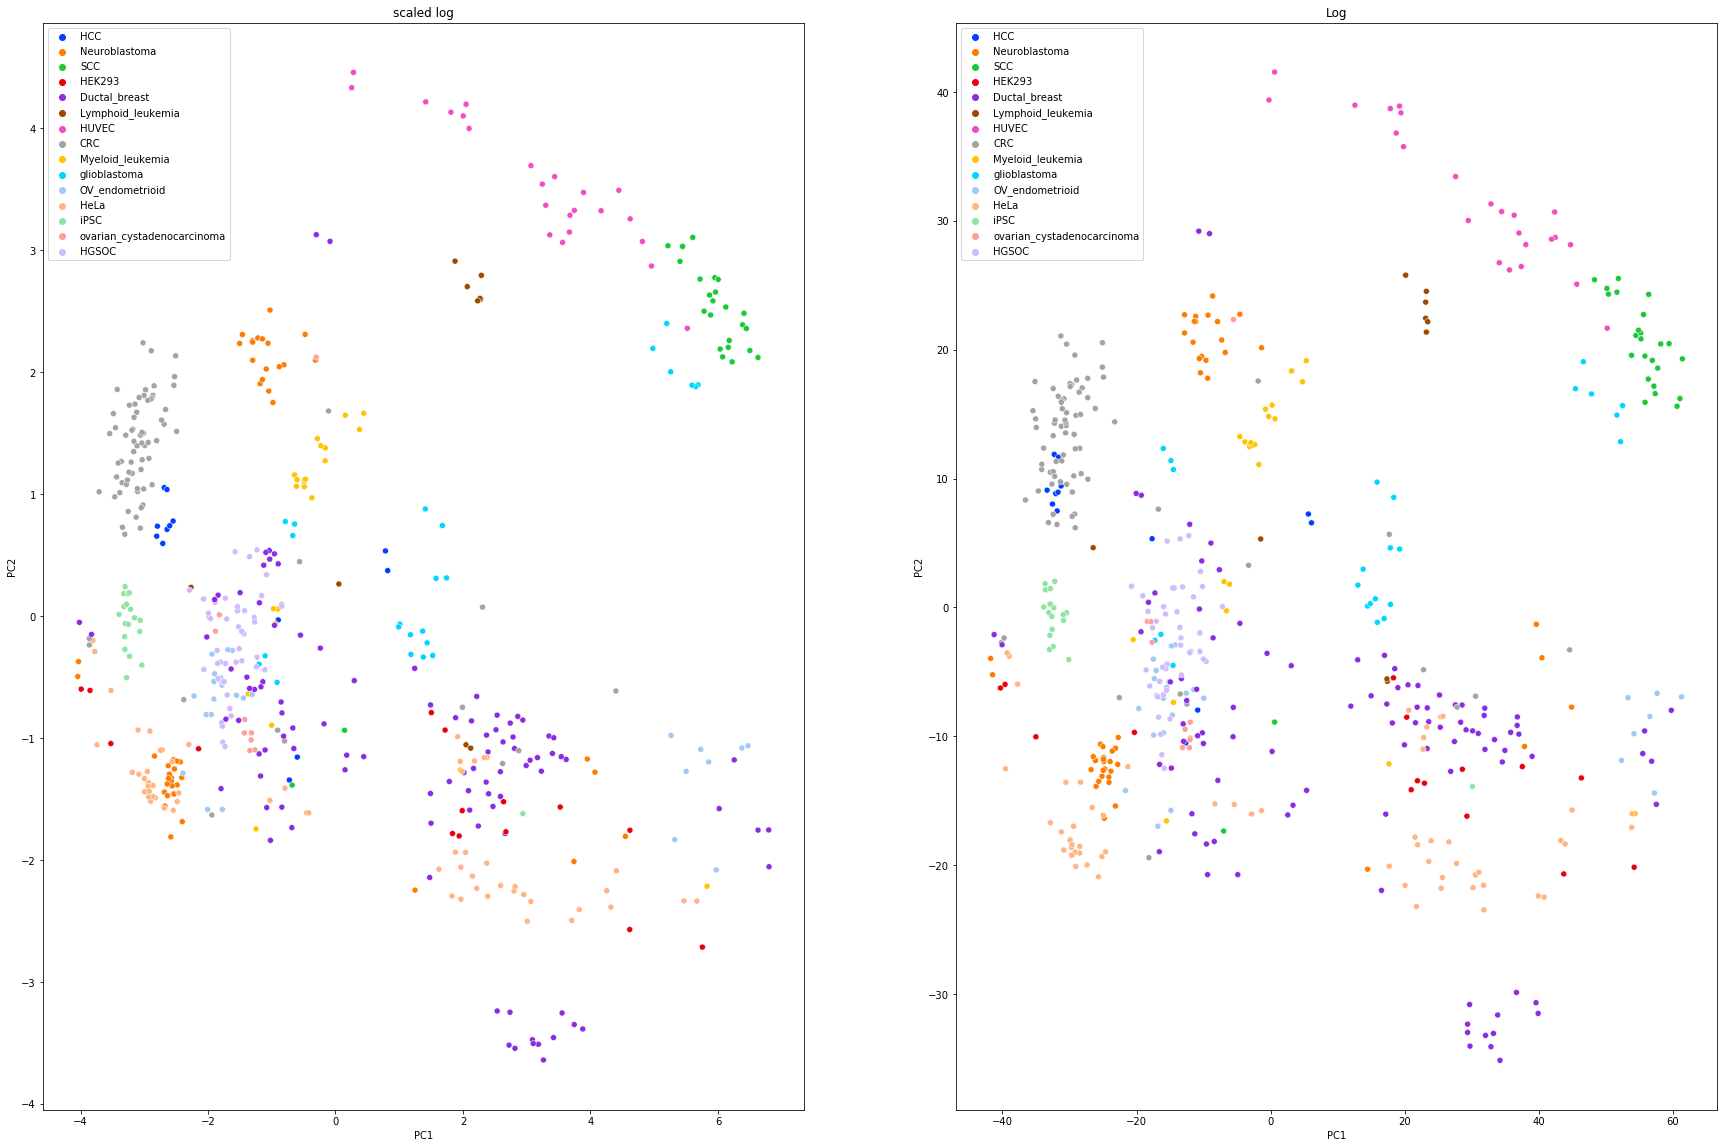

In [60]:
fig, ax = plt.subplots(1,2, figsize=(30,20))
pca = PCA(n_components=40)
pca2 = PCA(n_components=40)
embedding2 = pca.fit_transform(np.log2(imputed_data))
embedding1 = pca2.fit_transform(pd.DataFrame(MinMaxScaler().fit_transform(np.log2(imputed_data))))
embedding2 = pd.DataFrame(embedding2, columns=["PC"+str(x) for x in range(1,41)])
embedding1 = pd.DataFrame(embedding1, columns=["PC"+str(x) for x in range(1,41)])
sns.scatterplot(data=embedding1, x="PC1",y="PC2", hue=meta.Group.values, ax=ax[0], palette = colors)
sns.scatterplot(data=embedding2, x="PC1",y="PC2", hue=meta.Group.values, ax=ax[1], palette = colors)

ax[1].set_title("Log")
ax[0].set_title("scaled log")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

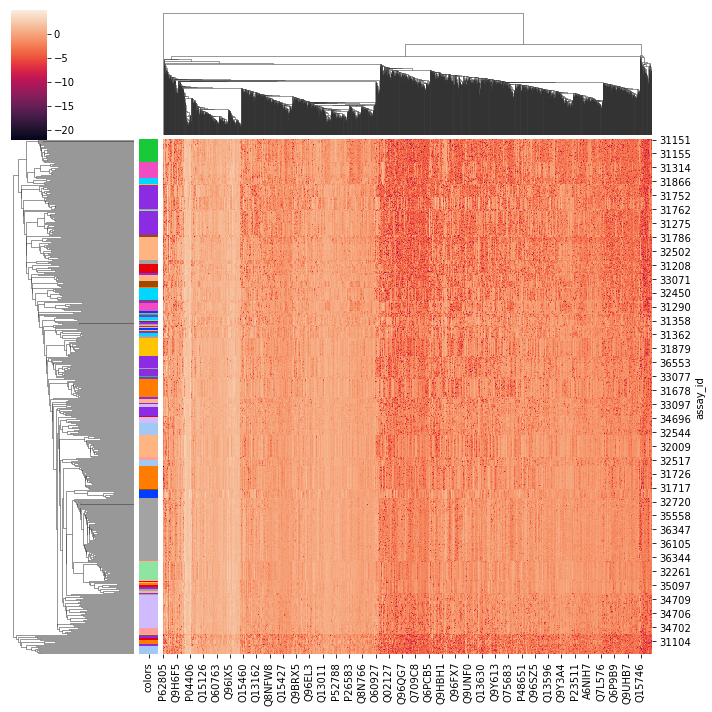

In [8]:
plt.figure(figsize=(10,10))
sns.clustermap(np.log2(imputed_data), row_colors=meta.colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 720x720 with 0 Axes>

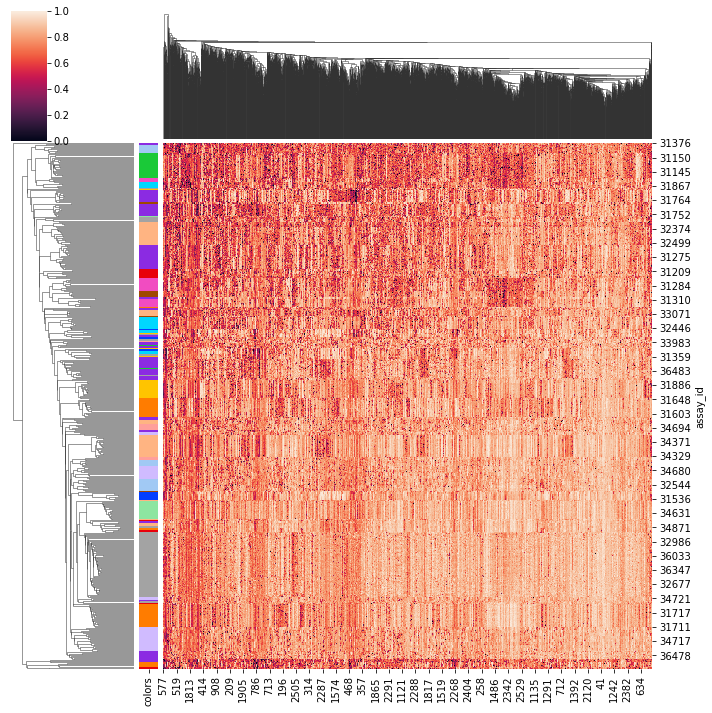

In [55]:
plt.figure(figsize=(10,10))
sns.clustermap(pd.DataFrame(MinMaxScaler().fit_transform(np.log2(imputed_data)), index=imputed_data.index), row_colors=meta.colors)

In [9]:
class LowestValueImputerGaussian(BaseEstimator, TransformerMixin):
    '''
    Imputes by sampling from left shifted Gaussian distribution. Imputes 0 if protein was not identified in 50% of samples belonging to the class
    '''

    def __init__(self):
        self.fitted = False

    def generate_point(m, s):

        count = 0
        while count < 100:
            new_point = np.random.normal(m, s)

            if new_point > 0:
                return new_point
        return 0
    
    def impute(col: pd.Series):

        arr = np.array(col)
        m, s = np.nanmean(arr), np.nanstd(arr)

        new = np.array([generate_point(m-2.2*s, s*.3) if np.isnan(x) else x for x in arr])

        return pd.Series(new, index=col.index)
    
    def fit(self, X, y):

        self.mean_std_df = pd.DataFrame({"mean": X.mean(), "std": X.std()})

        imputed_data = exp_prep_data.apply(lambda x: impute(x), axis=1)

        # If protein columns has all nans, impute the lowest value in the dataframe
        self.impute_map = self.impute_map.fillna(self.impute_map.min())
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'impute_map')
        
        X = X.copy()

        for index, row in self.impute_map.iteritems():
            ind = X.index[X.loc[:,index].isna()]
            X.loc[ind, index] = X.loc[ind, index].fillna(self.impute_map[index])
        
        return X

In [147]:
# Imputation method

def generate_point(m, s):

    count = 0
    while count < 100:
        new_point = np.random.normal(m, s)

        if new_point > 0:
            return new_point
        else:
            return 0


def impute(col: pd.Series):

    arr = np.array(col)
    m, s = np.nanmean(arr), np.nanstd(arr)
    new = np.array([generate_point(m-2.2*s, s/2) if np.isnan(x) else x for x in arr])

    return pd.Series(new, index=col.index)

imputed_data = exp_prep_data.apply(lambda x: impute(x), axis=1)

In [10]:
imputer = LowestValueImputerGaussian()

In [12]:
imputer.fit(exp_prep_data, False)

AttributeError: 'LowestValueImputerGaussian' object has no attribute 'impute_map'

In [ ]:
imputed_data = imputer.transform(exp_prep_data)

In [108]:
pd.Series([np.random.normal(m-2.2*s, s) if np.isnan(x) else x for x in np.array(exp_prep_data.iloc[4])], index=exp_prep_data.columns)



A0AVT1    0.025416
A0MZ66   -0.018105
A0PJW6    0.039694
A1X283    0.033274
A2RRP1    0.106508
            ...   
Q9Y6W3   -0.116605
Q9Y6W5    0.031676
Q9Y6X9    0.030858
Q9Y6Y0   -0.090943
Q9Y6Y8    0.307507
Length: 2615, dtype: float64

In [ ]:
target_encoder.inverse_transform()

0.9994
0.3595
0.8073
0.4755
0.8614
0.2203
0.6574
0.5585
0.9828
0.9192


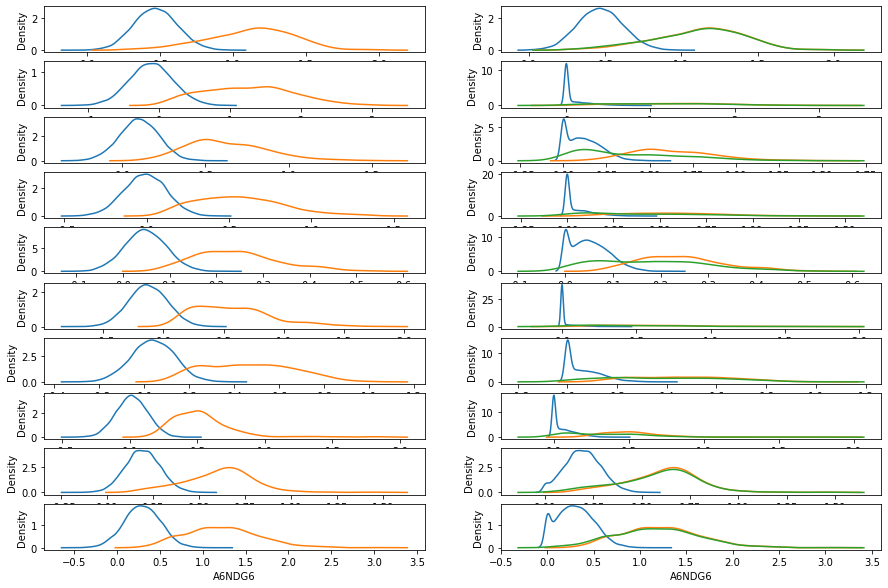

In [9]:
# The new imputation method

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10) = plt.subplots(10,2, figsize=(15,10))

for i, axes in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]):
    
    prot = mean_std_df.index[i]
    m = mean_std_df.loc[prot, "mean"]
    s = mean_std_df.loc[prot, "std"]
    
    samples = np.random.normal(m - 2.2*s, s/2, 10000)
    sns.kdeplot(samples, ax=axes[0])
    sns.kdeplot(exp_prep_data.loc[:,prot], ax=axes[0])
    sample1_count = samples[samples >= 0].shape[0]

    print(sample1_count/len(samples))

    samples[samples<0] = 0
    sns.kdeplot(samples, ax=axes[1])
    sns.kdeplot(exp_prep_data.loc[:,prot], ax=axes[1])

    sns.kdeplot(imputed_data.loc[:,prot], ax=axes[1])

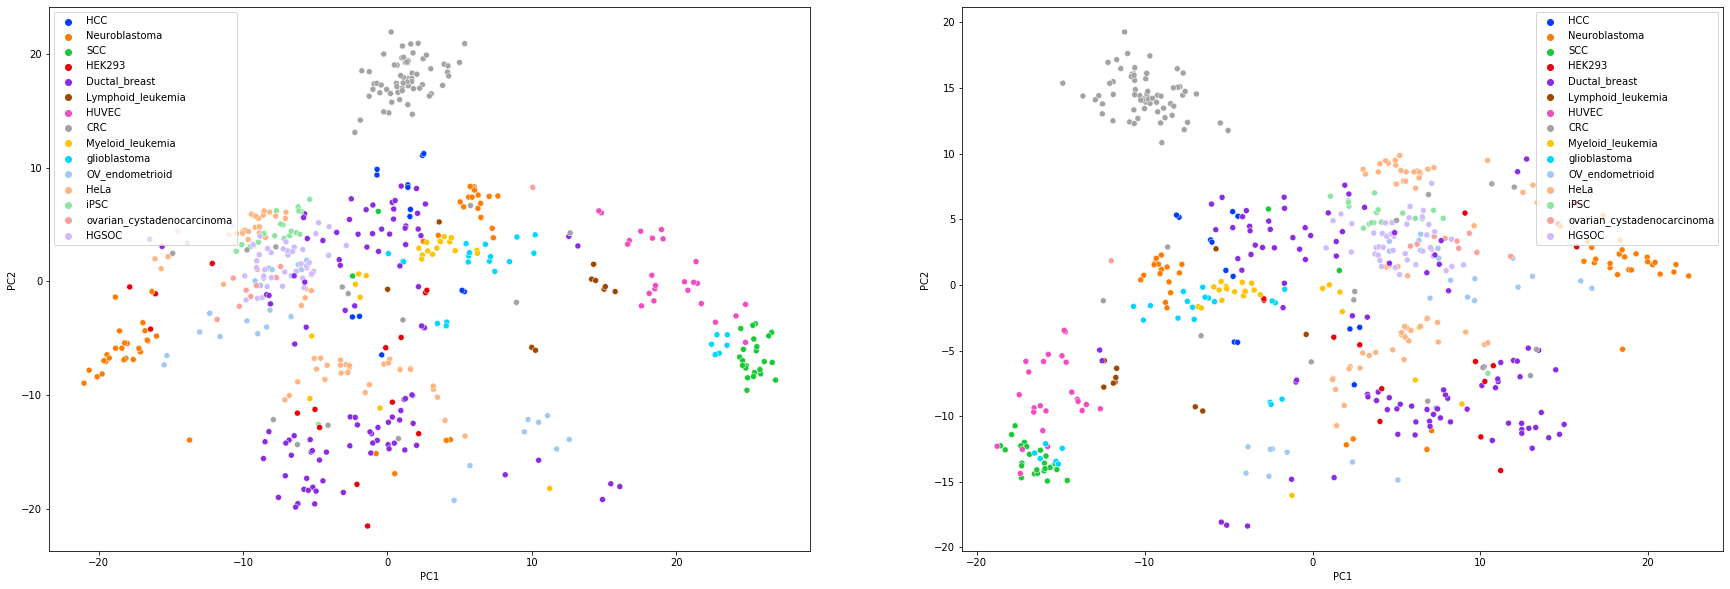

In [10]:
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

fig, ax = plt.subplots(1,2, figsize=(30,10))
pca = PCA(n_components=40)
pca2 = PCA(n_components=40)
embedding2 = pca.fit_transform(imputed_data)
embedding1 = pca2.fit_transform(exp_prep_data.fillna(0))
embedding2 = pd.DataFrame(embedding2, columns=["PC"+str(x) for x in range(1,41)])
embedding1 = pd.DataFrame(embedding1, columns=["PC"+str(x) for x in range(1,41)])
sns.scatterplot(data=embedding1, x="PC1",y="PC2", hue=meta.Group.values, ax=ax[0], palette = colors)
sns.scatterplot(data=embedding2, x="PC1",y="PC2", hue=meta.Group.values, ax=ax[1], palette = colors)

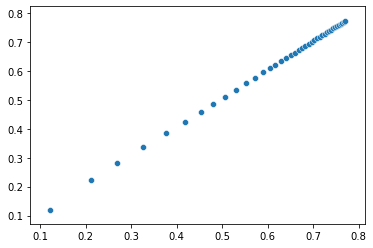

In [11]:
sns.scatterplot(x=np.cumsum(pca.explained_variance_ratio_), y= np.cumsum(pca2.explained_variance_ratio_))

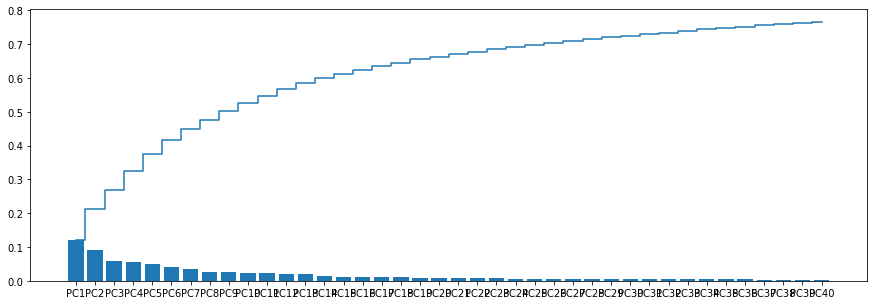

In [171]:
plt.figure(figsize=(15,5))
plt.bar(x=["PC"+str(x) for x in range(1,41)], height=pca.explained_variance_ratio_)
plt.step(range(0,len(np.cumsum(pca.explained_variance_ratio_))), np.cumsum(pca.explained_variance_ratio_), where='mid',label='Cumulative explained variance')

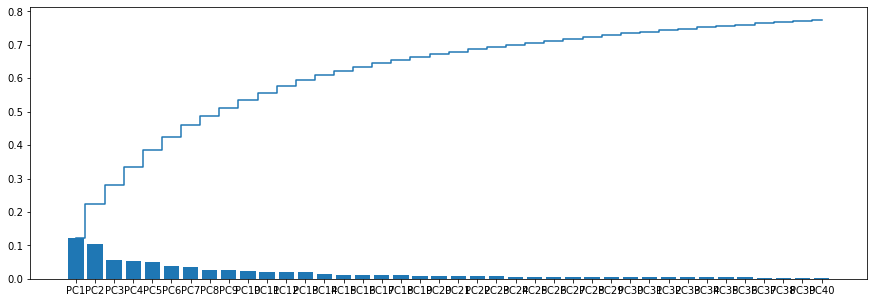

In [172]:
plt.figure(figsize=(15,5))
plt.bar(x=["PC"+str(x) for x in range(1,41)], height=pca2.explained_variance_ratio_)
plt.step(range(0,len(np.cumsum(pca2.explained_variance_ratio_))), np.cumsum(pca2.explained_variance_ratio_), where='mid',label='Cumulative explained variance')

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


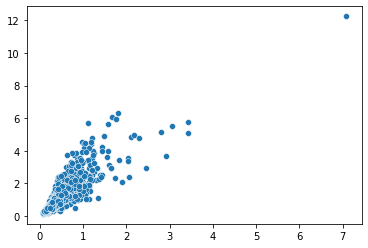

In [31]:
sns.scatterplot(exp_prep_data.std(),exp_prep_data.mean())

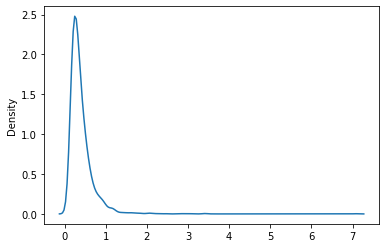

In [16]:
sns.kdeplot(exp_prep_data.std())

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


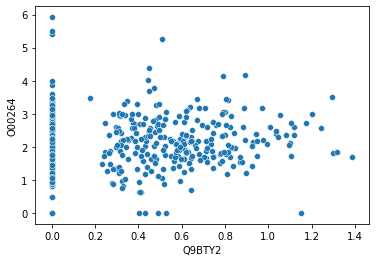

In [27]:
sns.scatterplot(exp_prep_data.iloc[:,2000], exp_prep_data.iloc[:,30])

(-0.5757575757575758, 0.00010143202710198309)

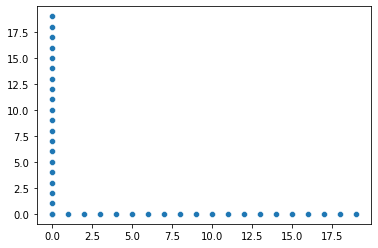

In [14]:
sns.scatterplot(x=list(range(20))+[0]*20, y= [0]*20 +list(range(20)))
pearsonr(x=list(range(20))+[0]*20, y =  [0]*20 +list(range(20)))

In [53]:
filter_ = uml.FilterByClass(keep=True)
exp_prep_data = filter_.fit_transform(np.exp2(data), targets)
exp_prep_data = pd.DataFrame(exp_prep_data, columns = filter_.filtered_proteins)
exp_prep_data.fillna(0, inplace=True)

In [56]:
exp_prep_data = exp_prep_data.T

In [4]:
prep_data = pd.DataFrame(prep_data, columns=preprocessor.named_steps.filter.filtered_proteins)

In [5]:
transp_data = prep_data.T
norm_transp_data = MinMaxScaler().fit_transform(transp_data)
norm_transp_data = pd.DataFrame(norm_transp_data, index = transp_data.index)

In [14]:
pd.DataFrame({"encoding": unique_labels, "label": target_encoder.inverse_transform(unique_labels)}).sort_values(by="encoding")

encoding                       label
7          0                         CRC
4          1               Ductal_breast
0          2                         HCC
3          3                      HEK293
14         4                       HGSOC
6          5                       HUVEC
11         6                        HeLa
5          7           Lymphoid_leukemia
8          8            Myeloid_leukemia
1          9               Neuroblastoma
10        10             OV_endometrioid
2         11                         SCC
9         12                glioblastoma
12        13                        iPSC
13        14  ovarian_cystadenocarcinoma

In [39]:
norm_transp_data.loc[:,targets==6]

229       230       231       232       233       234       246  \
Q9UNA1  0.263027  0.261255  0.256404  0.257296  0.259466  0.260340  0.257655   
Q6GQQ9  0.483729  0.432536  0.500089  0.431166  0.433636  0.509214  0.426575   
Q9ULJ7  0.400014  0.394222  0.483641  0.469701  0.444790  0.398966  0.289285   
O75352  0.570273  0.566432  0.555914  0.557848  0.562552  0.564447  0.558626   
O95425  0.217542  0.216076  0.212064  0.365984  0.214596  0.215319  0.213099   
...          ...       ...       ...       ...       ...       ...       ...   
P52739  0.579794  0.562573  0.493029  0.525742  0.500781  0.502229  0.356251   
P26885  0.613989  0.609854  0.598529  0.600612  0.605677  0.607716  0.601450   
Q9H6X2  0.359172  0.356753  0.350128  0.351347  0.354310  0.355503  0.351837   
Q13443  0.448241  0.445222  0.436955  0.438475  0.442173  0.443662  0.439087   
P36969  0.512900  0.509446  0.499986  0.501725  0.505957  0.507660  0.502425   

             247       248       249  ...       362       363       364  \
Q9UNA1  0.258761  0.260440  0.262233  ...  0.254106  0.261443  0.256293   
Q6GQQ9  0.547684  0.486569  0.434155  ...  0.483923  0.534754  0.424320   
Q9ULJ7  0.290527  0.292412  0.294425  ...  0.524038  0.477241  0.484641   
O75352  0.561024  0.564665  0.568552  ...  0.550932  0.566839  0.555673   
O95425  0.214013  0.215402  0.216885  ...  0.210164  0.216232  0.211972   
...          ...       ...       ...  ...       ...       ...       ...   
P52739  0.357780  0.360102  0.513023  ...  0.476682  0.556083  0.494269   
P26885  0.604031  0.607951  0.612137  ...  0.593165  0.610292  0.598270   
Q9H6X2  0.525390  0.355640  0.521154  ...  0.483673  0.357009  0.349977   
Q13443  0.440971  0.443833  0.446889  ...  0.433039  0.445542  0.436766   
P36969  0.504582  0.507857  0.511353  ...  0.495505  0.509812  0.499770   

             365       366       367       368       369       432       433  
Q9UNA1  0.256788  0.253347  0.255761  0.252527  0.255913  0.248476  0.240717  
Q6GQQ9  0.435793  0.507086  0.496770  0.504090  0.478006  0.562709  0.530572  
Q9ULJ7  0.399540  0.425022  0.480622  0.483290  0.442707  0.555443  0.538728  
O75352  0.556745  0.549287  0.554519  0.547508  0.554850  0.538724  0.521902  
O95425  0.212381  0.209536  0.211532  0.208857  0.211658  0.296651  0.239998  
...          ...       ...       ...       ...       ...       ...       ...  
P52739  0.355052  0.434233  0.353632  0.524740  0.353843  0.505046  0.522807  
P26885  0.599425  0.591394  0.597028  0.589479  0.597383  0.580022  0.561910  
Q9H6X2  0.350652  0.514764  0.543150  0.484204  0.349458  0.512251  0.508626  
Q13443  0.437608  0.431746  0.435858  0.430347  0.436118  0.423443  0.410221  
P36969  0.500734  0.494025  0.498731  0.492425  0.499029  0.484526  0.469396  

[8774 rows x 60 columns]

In [40]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 5, 100),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(norm_transp_data.loc[:,targets==6])

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 5, 100)},
             scoring=<function gmm_bic_score at 0x7ff21da40170>)

In [41]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance      BIC score
1                    1               tied -370977.245283
3                    1               full -370977.245283
0                    1          spherical -117252.575937
2                    1               diag -117052.746315

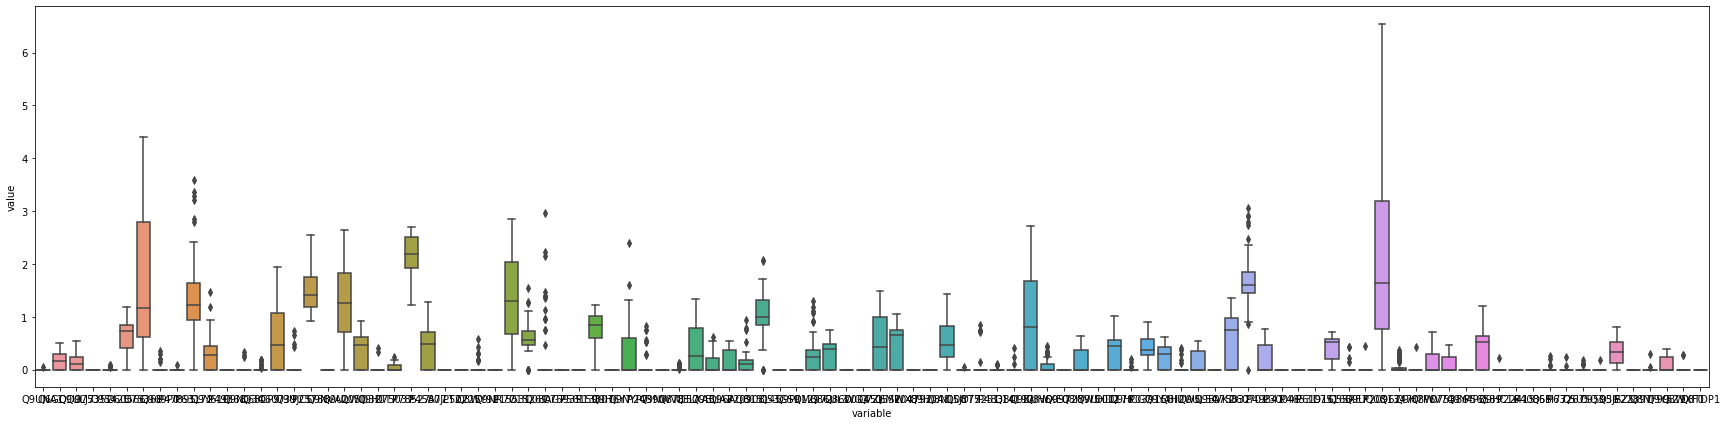

In [57]:
plt.figure(figsize=(30,7))
melted = exp_prep_data.loc[:,targets==6].T.melt()
prots = melted.variable.unique()[:100]

sns.boxplot(data=melted[melted.variable.isin(prots)], 
            y="value", x = "variable")

In [75]:
exp_prep_data

assay_id     30960     30961     31008     31009  31102  31103  31104  \
Q9UNA1    0.000000  0.072663  0.215304  0.101945    0.0    0.0    0.0   
Q6GQQ9    0.296329  0.421057  0.499602  0.494860    0.0    0.0    0.0   
Q9ULJ7    0.049832  0.140192  0.071229  0.091768    0.0    0.0    0.0   
O75352    0.793659  0.841303  0.527794  0.618581    0.0    0.0    0.0   
O95425    0.161298  0.164568  0.578427  0.573289    0.0    0.0    0.0   
...            ...       ...       ...       ...    ...    ...    ...   
P52739    0.084064  0.000000  0.000000  0.000000    0.0    0.0    0.0   
P26885    1.620613  1.722585  1.585621  1.527559    0.0    0.0    0.0   
Q9H6X2    0.000000  0.000000  0.000000  0.000000    0.0    0.0    0.0   
Q13443    0.195011  0.172848  0.321032  0.297799    0.0    0.0    0.0   
P36969    0.915184  0.969682  0.266455  0.263229    0.0    0.0    0.0   

assay_id     31105     31138     31139  ...     36533     36538     36543  \
Q9UNA1    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
Q6GQQ9    0.000000  0.319951  0.328034  ...  0.387073  0.295092  0.249761   
Q9ULJ7    0.000000  0.000000  0.000000  ...  0.198961  0.000000  0.000000   
O75352    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
O95425    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
...            ...       ...       ...  ...       ...       ...       ...   
P52739    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
P26885    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
Q9H6X2    0.386353  0.000000  0.000000  ...  0.330255  0.361173  0.000000   
Q13443    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
P36969    0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

assay_id     36548     36553     36558  36563  36568     36573     36578  
Q9UNA1    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
Q6GQQ9    0.351444  0.265745  0.271128    0.0    0.0  0.296375  0.330094  
Q9ULJ7    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
O75352    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
O95425    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
...            ...       ...       ...    ...    ...       ...       ...  
P52739    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
P26885    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
Q9H6X2    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
Q13443    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  
P36969    0.000000  0.000000  0.000000    0.0    0.0  0.000000  0.000000  

[8774 rows x 518 columns]

In [74]:
((exp_prep_data == 0).sum(axis=1)/518 == 1).sum()

0

In [76]:
sum(targets==6)

60

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


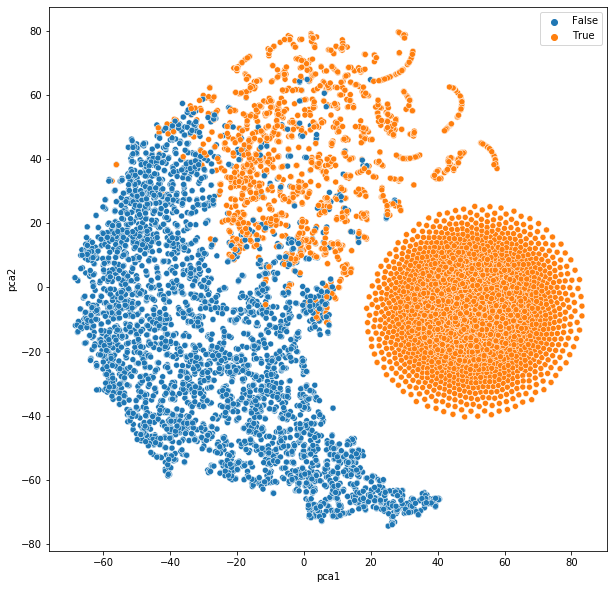

In [77]:
plt.figure(figsize=(10,10))

pca = TSNE(perplexity=10)

embeddings = pca.fit_transform(exp_prep_data.loc[:,targets==6])
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = ((exp_prep_data.loc[:,targets==6] == 0).sum(axis=1)/sum(targets==6) > .80).values)

In [79]:
((exp_prep_data.loc[:,targets==6] == 0).sum(axis=1)/sum(targets==6) ==1).sum()

2211

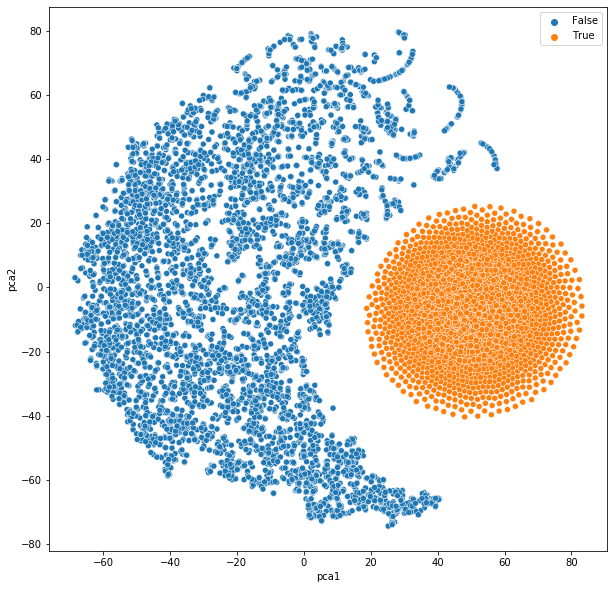

In [78]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2", hue = ((exp_prep_data.loc[:,targets==6] == 0).sum(axis=1)/sum(targets==6) ==1).values)

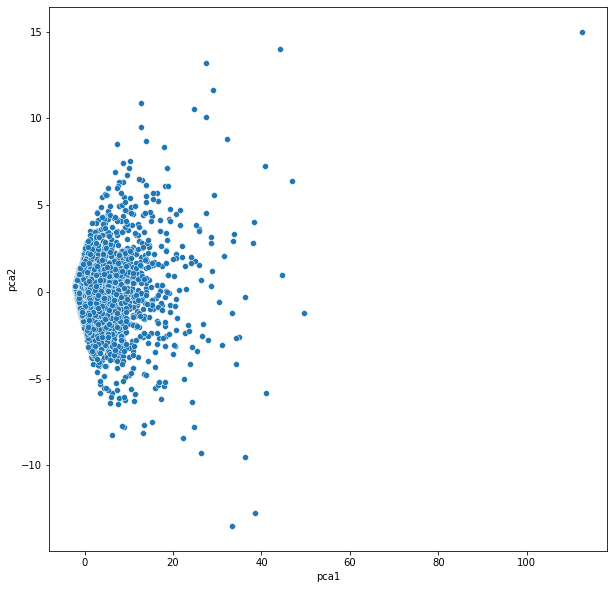

In [59]:
plt.figure(figsize=(10,10))

pca = PCA(n_components=2)

embeddings = pca.fit_transform(exp_prep_data.loc[:,targets==6])
sns.scatterplot(data=pd.DataFrame(embeddings, columns = ["pca1", "pca2"]), x= "pca1", y = "pca2")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


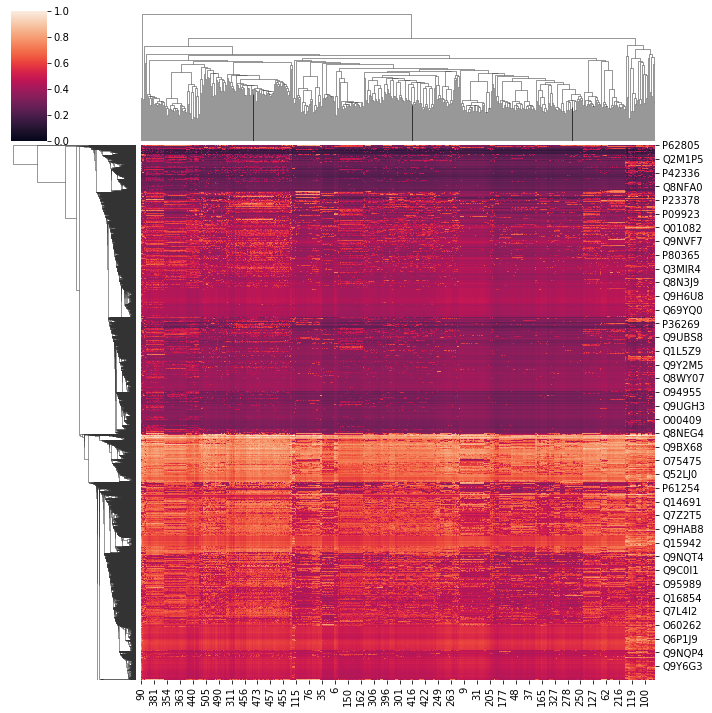

In [33]:
sns.clustermap(norm_transp_data)

In [28]:
(pd.DataFrame(embeddings, columns = ["pca1", "pca2"]) > 3).pca2

0       False
1       False
2       False
3       False
4       False
        ...  
8769    False
8770    False
8771    False
8772    False
8773    False
Name: pca2, Length: 8774, dtype: bool

In [29]:
norm_transp_data.index[(pd.DataFrame(embeddings, columns = ["pca1", "pca2"]) > 3).pca2]

Index(['P35998'], dtype='object')